In [1]:
import pandas as pd
import numpy as np
import re
from experiment_utils import get_latest_files
from post_processing import series_name,combined_box_violin_plots, error_estimation, merge_estimates_true, compute_val_metrics, under_over_analysis, under_over_by_method, val_metrics_per_iteration, boxplots, boxplots_per_iteration, add_weights, exponential_weights_paper

Functions

In [2]:
def clean_filename(filepath):
    filename = filepath.split('/')[-1]
    
    filename = filename.rsplit('.', 1)[0]
    
    # Check if the filename ends with a date in the format DDMMYYYY or similar
    # and remove the date if it exists
    filename = re.sub(r'_\d{8}$', '', filename)
    
    return filename

def clean_method(method_str):
    parts = method_str.split('.')
    if len(parts) > 3:
        method_name = parts[3].split()[0]
    else:
        method_name = parts[-1].split()[0]
    return method_name

## Upload Data

!TODO be carefull with "get_latest_files" when lstm results are ready

In [3]:
[get_latest_files('results/saude', 'table_A'), 
get_latest_files('results/transportes', 'table_A'), 
get_latest_files('results/eco_financas', 'table_A'), 
get_latest_files('results/eng_ciencias', 'table_A'), 
get_latest_files('results/energia', 'table_A'), 
get_latest_files('results/ambiente', 'table_A'), 
get_latest_files('results/meteorologia', 'table_A')]

['results/saude\\table_A_saude_2024_06_06__15_04_07.csv',
 'results/transportes\\table_A_transportes_2024_06_06__10_53_40.csv',
 'results/eco_financas\\table_A_eco_financas_2024_06_06__17_36_19.csv',
 'results/eng_ciencias\\table_A_eng_ciencias_2024_06_06__20_15_36.csv',
 'results/energia\\table_A_energia_2024_06_06__17_51_10.csv',
 'results/ambiente\\table_A_ambiente_2024_06_07__10_15_12.csv',
 'results/meteorologia\\table_A_meteorologia_2024_06_07__15_27_00.csv']

In [4]:
# Validation Results
saude = pd.read_csv('results/saude\\table_A_saude_2024_06_06__15_04_07.csv', dtype={'column_index': 'string'})
transportes = pd.read_csv('results/transportes\\table_A_transportes_2024_06_06__10_53_40.csv', dtype={'column_index': 'string'})
eco_financas = pd.read_csv('results/eco_financas\\table_A_eco_financas_2024_06_06__17_36_19.csv', dtype={'column_index': 'string'})
eng_ciencias = pd.read_csv('results/eng_ciencias\\table_A_eng_ciencias_2024_06_06__20_15_36.csv', dtype={'column_index': 'string'})
energia = pd.read_csv('results/energia\\table_A_energia_2024_06_06__17_51_10.csv', dtype={'column_index': 'string'})
ambiente = pd.read_csv('results/ambiente\\table_A_ambiente_2024_06_07__10_15_12.csv', dtype={'column_index': 'string'})
meteorologia = pd.read_csv('results/meteorologia\\table_A_meteorologia_2024_06_07__15_27_00.csv', dtype={'column_index': 'string'})

val_dict = {'saude': saude,
 'transportes': transportes,
 'eco_financas':eco_financas,
 'eng_ciencias': eng_ciencias,
 'energia': energia,
 'ambiente': ambiente,
 'meteorologia': meteorologia
 }

In [5]:
real_data_val = pd.concat(val_dict).reset_index(0).rename(columns={'level_0': 'Field'})
real_data_val

,Field,filename,column_index,method,iteration,model,mse,mae,rmse
0,saude,datasets/processed_data/covid19_17052024.csv,0,<timecave.validation_methods.OOS.Holdout objec...,0,Tree,1122.564394,20.017677,33.504692
1,saude,datasets/processed_data/covid19_17052024.csv,0,<timecave.validation_methods.OOS.Holdout objec...,0,ARMA,1097.670935,20.360957,33.131117
2,saude,datasets/processed_data/covid19_17052024.csv,0,<timecave.validation_methods.OOS.Repeated_Hold...,0,Tree,197.821429,8.396104,14.064901
3,saude,datasets/processed_data/covid19_17052024.csv,0,<timecave.validation_methods.OOS.Repeated_Hold...,0,ARMA,4652.950871,64.066829,68.212542
4,saude,datasets/processed_data/covid19_17052024.csv,0,<timecave.validation_methods.OOS.Repeated_Hold...,1,Tree,182.480132,8.099338,13.508521
...,...,...,...,...,...,...,...,...,...
2725,meteorologia,datasets/processed_data/MLTempDataset_13052024...,0,<timecave.validation_methods.markov.MarkovCV o...,7,ARMA,47.402579,5.636406,6.884953
2726,meteorologia,datasets/processed_data/MLTempDataset_13052024...,0,<timecave.validation_methods.markov.MarkovCV o...,8,Tree,63.853138,5.510571,7.990816
2727,meteorologia,datasets/processed_data/MLTempDataset_13052024...,0,<timecave.validation_methods.markov.MarkovCV o...,8,ARMA,52.510323,5.949948,7.246401
2728,meteorologia,datasets/processed_data/MLTempDataset_13052024...,0,<timecave.validation_methods.markov.MarkovCV o...,9,Tree,74.284770,6.082853,8.618861


In [6]:
[get_latest_files('results/saude', 'table_B'), 
get_latest_files('results/transportes', 'table_B'), 
get_latest_files('results/eco_financas', 'table_B'), 
get_latest_files('results/eng_ciencias', 'table_B'), 
get_latest_files('results/energia', 'table_B'), 
get_latest_files('results/ambiente', 'table_B'), 
get_latest_files('results/meteorologia', 'table_B')]

['results/saude\\table_B_saude_2024_06_06__15_04_07.csv',
 'results/transportes\\table_B_transportes_2024_06_06__10_53_40.csv',
 'results/eco_financas\\table_B_eco_financas_2024_06_06__17_36_19.csv',
 'results/eng_ciencias\\table_B_eng_ciencias_2024_06_06__20_15_36.csv',
 'results/energia\\table_B_energia_2024_06_06__17_51_10.csv',
 'results/ambiente\\table_B_ambiente_2024_06_07__10_15_12.csv',
 'results/meteorologia\\table_B_meteorologia_2024_06_07__15_27_00.csv']

In [7]:
# Test Results
saude_test = pd.read_csv('results/saude\\table_B_saude_2024_06_06__15_04_07.csv', dtype={'column_index': 'string'})
transportes_test = pd.read_csv('results/transportes\\table_B_transportes_2024_06_06__10_53_40.csv', dtype={'column_index': 'string'})
eco_financas_test = pd.read_csv('results/eco_financas\\table_B_eco_financas_2024_06_06__17_36_19.csv', dtype={'column_index': 'string'})
eng_ciencias_test = pd.read_csv('results/eng_ciencias\\table_B_eng_ciencias_2024_06_06__20_15_36.csv', dtype={'column_index': 'string'})
energia_test = pd.read_csv('results/energia\\table_B_energia_2024_06_06__17_51_10.csv', dtype={'column_index': 'string'})
ambiente_test = pd.read_csv('results/ambiente\\table_B_ambiente_2024_06_07__10_15_12.csv', dtype={'column_index': 'string'})
meteorologia_test = pd.read_csv('results/meteorologia\\table_B_meteorologia_2024_06_07__15_27_00.csv', dtype={'column_index': 'string'})

test_dict = {'saude': saude_test,
 'transportes': transportes_test,
 'eco_financas':eco_financas_test,
 'eng_ciencias': eng_ciencias_test,
 'energia': energia_test,
 'ambiente': ambiente_test,
 'meteorologia': meteorologia_test
 }

In [8]:
real_data_test = pd.concat(test_dict).reset_index(0).rename(columns={'level_0': 'Field'})
real_data_test

,Field,filename,column_index,model,mse,mae,rmse
0,saude,datasets/processed_data/covid19_17052024.csv,0,Tree,17.316252,2.493517,4.161280
1,saude,datasets/processed_data/covid19_17052024.csv,0,ARMA,35.113134,5.037637,5.925634
2,saude,datasets/processed_data/covid19_17052024.csv,1,Tree,5.463435,1.555446,2.337399
3,saude,datasets/processed_data/covid19_17052024.csv,1,ARMA,14.434002,3.375995,3.799211
4,saude,datasets/processed_data/covid19_17052024.csv,2,Tree,8.104641,1.812699,2.846865
...,...,...,...,...,...,...,...
65,meteorologia,datasets/processed_data/jena_climate_data.csv,12,ARMA,23783.710487,4.231992,154.219683
66,meteorologia,datasets/processed_data/jena_climate_data.csv,13,Tree,6025.325689,40.736198,77.622971
67,meteorologia,datasets/processed_data/jena_climate_data.csv,13,ARMA,7167.891640,68.984216,84.663402
68,meteorologia,datasets/processed_data/MLTempDataset_13052024...,0,Tree,10.731559,1.387957,3.275906


# Real Data

## Saúde

In [9]:
real_data_val['filename'] = real_data_val['filename'].apply(clean_filename)
real_data_val['method'] = real_data_val['method'].apply(clean_method)
real_data_val = series_name(real_data_val)
real_data_val

,series,Field,method,iteration,model,mse,mae,rmse
0,covid19_0,saude,Holdout,0,Tree,1122.564394,20.017677,33.504692
1,covid19_0,saude,Holdout,0,ARMA,1097.670935,20.360957,33.131117
2,covid19_0,saude,Repeated_Holdout,0,Tree,197.821429,8.396104,14.064901
3,covid19_0,saude,Repeated_Holdout,0,ARMA,4652.950871,64.066829,68.212542
4,covid19_0,saude,Repeated_Holdout,1,Tree,182.480132,8.099338,13.508521
...,...,...,...,...,...,...,...,...
2725,MLTempDataset_0,meteorologia,MarkovCV,7,ARMA,47.402579,5.636406,6.884953
2726,MLTempDataset_0,meteorologia,MarkovCV,8,Tree,63.853138,5.510571,7.990816
2727,MLTempDataset_0,meteorologia,MarkovCV,8,ARMA,52.510323,5.949948,7.246401
2728,MLTempDataset_0,meteorologia,MarkovCV,9,Tree,74.284770,6.082853,8.618861


In [10]:
real_data_test['filename'] = real_data_test['filename'].apply(clean_filename)
real_data_test = series_name(real_data_test)
real_data_test

,series,Field,model,mse,mae,rmse
0,covid19_0,saude,Tree,17.316252,2.493517,4.161280
1,covid19_0,saude,ARMA,35.113134,5.037637,5.925634
2,covid19_1,saude,Tree,5.463435,1.555446,2.337399
3,covid19_1,saude,ARMA,14.434002,3.375995,3.799211
4,covid19_2,saude,Tree,8.104641,1.812699,2.846865
...,...,...,...,...,...,...
65,jena_climate_data_12,meteorologia,ARMA,23783.710487,4.231992,154.219683
66,jena_climate_data_13,meteorologia,Tree,6025.325689,40.736198,77.622971
67,jena_climate_data_13,meteorologia,ARMA,7167.891640,68.984216,84.663402
68,MLTempDataset_0,meteorologia,Tree,10.731559,1.387957,3.275906


In [11]:
real_data_val = add_weights(real_data_val,preq_methods = ['Growing_Window', 'Rolling_Window'], CV_methods = ['Block_CV'])
real_data_val

,series,Field,method,iteration,model,mse,mae,rmse,weights
0,covid19_0,saude,Holdout,0,Tree,1122.564394,20.017677,33.504692,1.000000
1,covid19_0,saude,Holdout,0,ARMA,1097.670935,20.360957,33.131117,1.000000
2,covid19_0,saude,Repeated_Holdout,0,Tree,197.821429,8.396104,14.064901,1.000000
3,covid19_0,saude,Repeated_Holdout,0,ARMA,4652.950871,64.066829,68.212542,1.000000
4,covid19_0,saude,Repeated_Holdout,1,Tree,182.480132,8.099338,13.508521,1.000000
...,...,...,...,...,...,...,...,...,...
30547,MLTempDataset_0,meteorologia,Rolling_Window_with_weights,3,ARMA,37.253910,5.738725,6.103598,0.266667
30548,MLTempDataset_0,meteorologia,Rolling_Window_with_weights,1,Tree,17.250183,2.400754,4.153334,0.066667
30549,MLTempDataset_0,meteorologia,Rolling_Window_with_weights,1,ARMA,90.979230,7.153370,9.538303,0.066667
30550,MLTempDataset_0,meteorologia,Rolling_Window_with_weights,2,Tree,15.219104,2.088351,3.901167,0.133333


In [12]:
est_real_data_val = error_estimation(real_data_val)

In [13]:
estimates = merge_estimates_true(est_real_data_val, real_data_test)
estimates

,series,method,model,mse_estimate,mae_estimate,Field,mse_true,mae_true,rmse
0,DailyDelhiClimate_0,AdaptedhvBlockCV,ARMA,80.749119,7.123344,meteorologia,38.297620,4.821778,6.188507
1,DailyDelhiClimate_0,AdaptedhvBlockCV,Tree,5.906699,1.836843,meteorologia,5.927350,1.839508,2.434615
2,DailyDelhiClimate_0,Block_CV,ARMA,80.503973,7.126233,meteorologia,38.297620,4.821778,6.188507
3,DailyDelhiClimate_0,Block_CV,Tree,5.770700,1.850585,meteorologia,5.927350,1.839508,2.434615
4,DailyDelhiClimate_0,Block_CV_with_weights,ARMA,70.206565,6.978417,meteorologia,38.297620,4.821778,6.188507
...,...,...,...,...,...,...,...,...,...
5891,traffic_2,Repeated_Holdout,Tree,86.013504,5.127104,transportes,74.133196,5.250257,8.610064
5892,traffic_2,Rolling_Window,ARMA,124.217230,6.575690,transportes,131.889773,7.789359,11.484327
5893,traffic_2,Rolling_Window,Tree,77.258662,4.932268,transportes,74.133196,5.250257,8.610064
5894,traffic_2,Rolling_Window_with_weights,ARMA,136.505696,6.756850,transportes,131.889773,7.789359,11.484327


In [14]:
compute_val_metrics(estimates, 'mse')

,Mean,Median,1st_Quartile,3rd_Quartile,Minimum,Maximum,Standard_deviation,method,model,metric
0,-5.433608e+04,-1.018647e-08,-9.248379,21.211298,-1.144028e+07,1.155448e+07,1.235702e+06,AdaptedhvBlockCV,ARMA,PAE
1,1.643869e+05,1.557018e+01,0.275742,313.267122,2.061709e-08,1.155448e+07,1.225924e+06,AdaptedhvBlockCV,ARMA,APAE
2,8.399858e-01,2.647597e-03,-0.217666,0.674698,-9.998897e-01,2.154360e+01,2.790535e+00,AdaptedhvBlockCV,ARMA,RPAE
3,1.131530e+00,3.192090e-01,0.124873,0.806448,2.307294e-03,2.154360e+01,2.685573e+00,AdaptedhvBlockCV,ARMA,RAPAE
4,1.452218e+02,3.123722e-08,-3.915801,6.724306,-7.023322e+05,5.268196e+05,6.108240e+04,AdaptedhvBlockCV,Tree,PAE
...,...,...,...,...,...,...,...,...,...,...
83,1.153008e+00,2.803489e-01,0.081722,0.756059,9.925124e-04,2.796980e+01,3.242033e+00,Rolling_Window_with_weights,ARMA,RAPAE
84,2.374848e+04,1.007932e-02,-0.116593,26.387536,-6.238061e+05,4.501483e+06,2.969090e+05,Rolling_Window_with_weights,Tree,PAE
85,3.201758e+04,4.571309e+00,0.041059,132.920894,5.523761e-09,4.501483e+06,2.961314e+05,Rolling_Window_with_weights,Tree,APAE
86,9.972147e+06,9.459921e-02,-0.059811,2.031860,-9.999716e-01,2.672519e+09,1.629452e+08,Rolling_Window_with_weights,Tree,RPAE


In [15]:
under_over_analysis(estimates, 'mse')

(             Mean    Median  1st_Quartile  3rd_Quartile       Minimum  \
 0  -218722.969059 -9.567709   -208.844791     -0.042103 -1.144028e+07   
 1   218722.969059  9.567709      0.042103    208.844791  4.099003e-08   
 2       -0.291544 -0.218193     -0.419208     -0.083621 -9.998897e-01   
 3        0.291544  0.218193      0.083621      0.419208  2.307294e-03   
 4    -9327.162118 -4.148268    -80.991599     -0.001293 -7.023322e+05   
 ..            ...       ...           ...           ...           ...   
 83       0.289531  0.176816      0.071158      0.440175  1.886088e-03   
 84  -11192.522591 -3.272943    -41.582172     -0.027188 -6.238061e+05   
 85   11192.522591  3.272943      0.027188     41.582172  5.523761e-09   
 86      -0.250228 -0.153635     -0.361236     -0.048011 -9.999716e-01   
 87       0.250228  0.153635      0.048011      0.361236  9.662739e-04   
 
          Maximum  Standard_deviation    N      %                       method  \
 0  -4.099003e-08        1.4

In [16]:
under_over_by_method(estimates, 'mse')

(             Mean     Median  1st_Quartile  3rd_Quartile       Minimum  \
 0  -114812.267870  -5.479489    -99.096697     -0.003718 -1.144028e+07   
 1   114812.267870   5.479489      0.003718     99.096697  4.099003e-08   
 2       -0.291332  -0.212645     -0.414107     -0.071942 -9.999709e-01   
 3        0.291332   0.212645      0.071942      0.414107  1.170280e-03   
 4  -114123.665650  -6.668913    -94.953504     -0.004632 -1.143580e+07   
 5   114123.665650   6.668913      0.004632     94.953504  4.373907e-08   
 6       -0.288347  -0.193704     -0.407933     -0.069610 -9.999708e-01   
 7        0.288347   0.193704      0.069610      0.407933  1.352814e-03   
 8   -65380.545566  -3.844774   -101.263989     -0.019662 -1.041102e+07   
 9    65380.545566   3.844774      0.019662    101.263989  4.543140e-10   
 10      -0.268624  -0.158496     -0.393251     -0.056072 -9.999713e-01   
 11       0.268624   0.158496      0.056072      0.393251  4.520206e-04   
 12  -68678.484728  -4.57

In [17]:
iteration_data = pd.merge(left=real_data_val, right=real_data_test, on=["model", "series"], suffixes=["_estimate", "_true"]);

In [18]:
val_metrics_per_iteration(iteration_data, 'mse', methods_list=['Rolling_Window_with_weights'])

method model iteration            PAE                \
                                                         mean        median   
0  Rolling_Window_with_weights  ARMA         1  141858.779741 -3.916060e-06   
1  Rolling_Window_with_weights  ARMA         2    3066.249636 -7.206647e-07   
2  Rolling_Window_with_weights  ARMA         3  279626.233255 -7.039472e-07   
3  Rolling_Window_with_weights  Tree         1   43828.181752  2.151681e-03   
4  Rolling_Window_with_weights  Tree         2   31764.938014  4.485639e-06   
5  Rolling_Window_with_weights  Tree         3    5692.169112  6.800463e-06   

                                                      APAE             ...  \
            min           max           std           mean     median  ...   
0 -3.705710e+07  6.916925e+07  3.779110e+06  357204.554944  11.399241  ...   
1 -3.283736e+07  5.430002e+07  2.899839e+06  257064.358036  16.002601  ...   
2 -6.747928e+06  8.895113e+07  5.463027e+06  404970.615134  15.285573  ...   
3 -6.859755e+05  1.578244e+07  7.058476e+05   50538.484899   5.484761  ...   
4 -4.850596e+05  1.380339e+07  6.131452e+05   40890.015008   4.428622  ...   
5 -9.481379e+05  2.195719e+06  1.514340e+05   16611.385750   3.911539  ...   

           RPAE                                                         RAPAE  \
           mean    median       min           max           std          mean   
0  8.765981e-01 -0.040998 -1.000000  4.508412e+01  3.924112e+00  1.320366e+00   
1  8.928042e-01 -0.015772 -1.000000  4.709735e+01  4.161825e+00  1.267080e+00   
2  8.491961e-01 -0.019959 -0.999889  3.772787e+01  4.110236e+00  1.245035e+00   
3  4.912286e+06  0.055705 -1.000000  2.626498e+09  1.134472e+08  4.912286e+06   
4  1.241103e+07  0.033834 -1.000000  6.645483e+09  2.870407e+08  1.241103e+07   
5  1.006320e+07  0.038805 -0.999972  2.696936e+09  1.647416e+08  1.006320e+07   

                                                   
     median       min           max           std  
0  0.403638  0.001738  4.508412e+01  3.797616e+00  
1  0.326482  0.000350  4.709735e+01  4.063358e+00  
2  0.367064  0.005218  3.772787e+01  4.007737e+00  
3  0.418288  0.001518  2.626498e+09  1.134472e+08  
4  0.328569  0.000949  6.645483e+09  2.870407e+08  
5  0.365811  0.001584  2.696936e+09  1.647416e+08  

[6 rows x 23 columns]

In [19]:
iteration_data.method.unique()

array(['Holdout', 'Repeated_Holdout', 'Growing_Window', 'Rolling_Window',
       'Block_CV', 'AdaptedhvBlockCV', 'MarkovCV',
       'Block_CV_with_weights_paper', 'Block_CV_with_weights',
       'Growing_Window_with_weights', 'Rolling_Window_with_weights'],
      dtype=object)

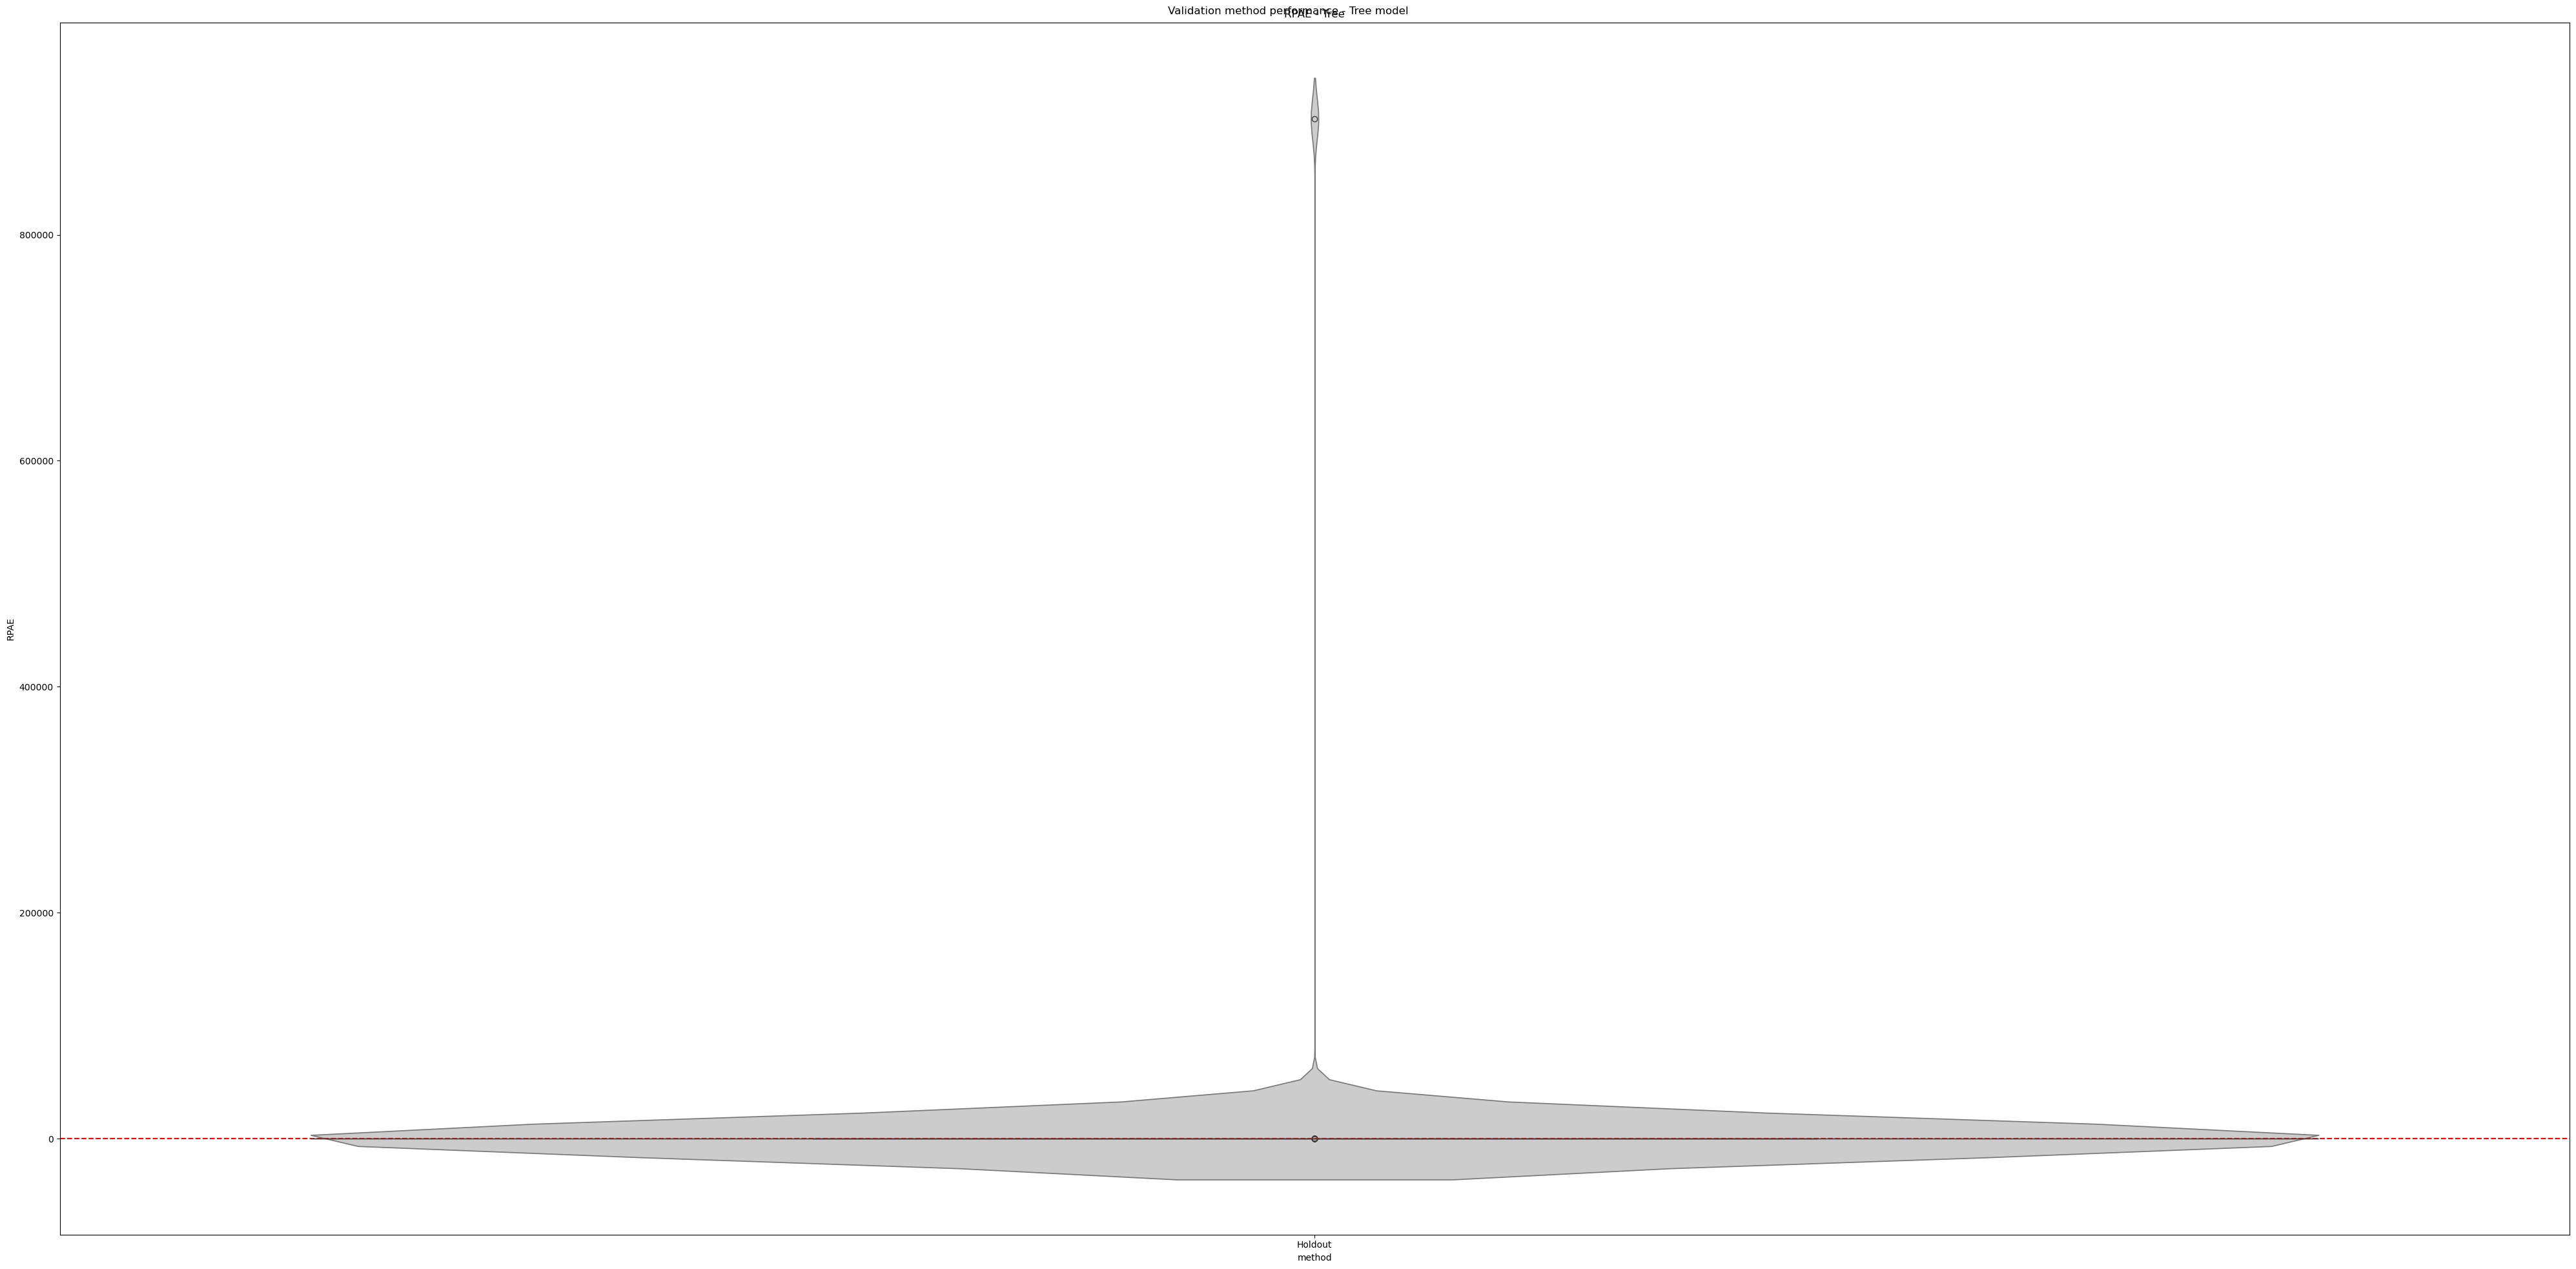

In [20]:
methods = ['Holdout']
it = iteration_data.loc[iteration_data["method"].isin(methods)].copy()
combined_box_violin_plots(it, "mse", "Tree", ["RPAE"], 20, 40)

c:\Users\User\Desktop\Project_repos\tsvalidation\tsvalidation\experiments\post_processing.py:331: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fig = boxplot[0].get_figure() if isinstance(boxplot, pd.Series) else boxplot[0, 0].get_figure()


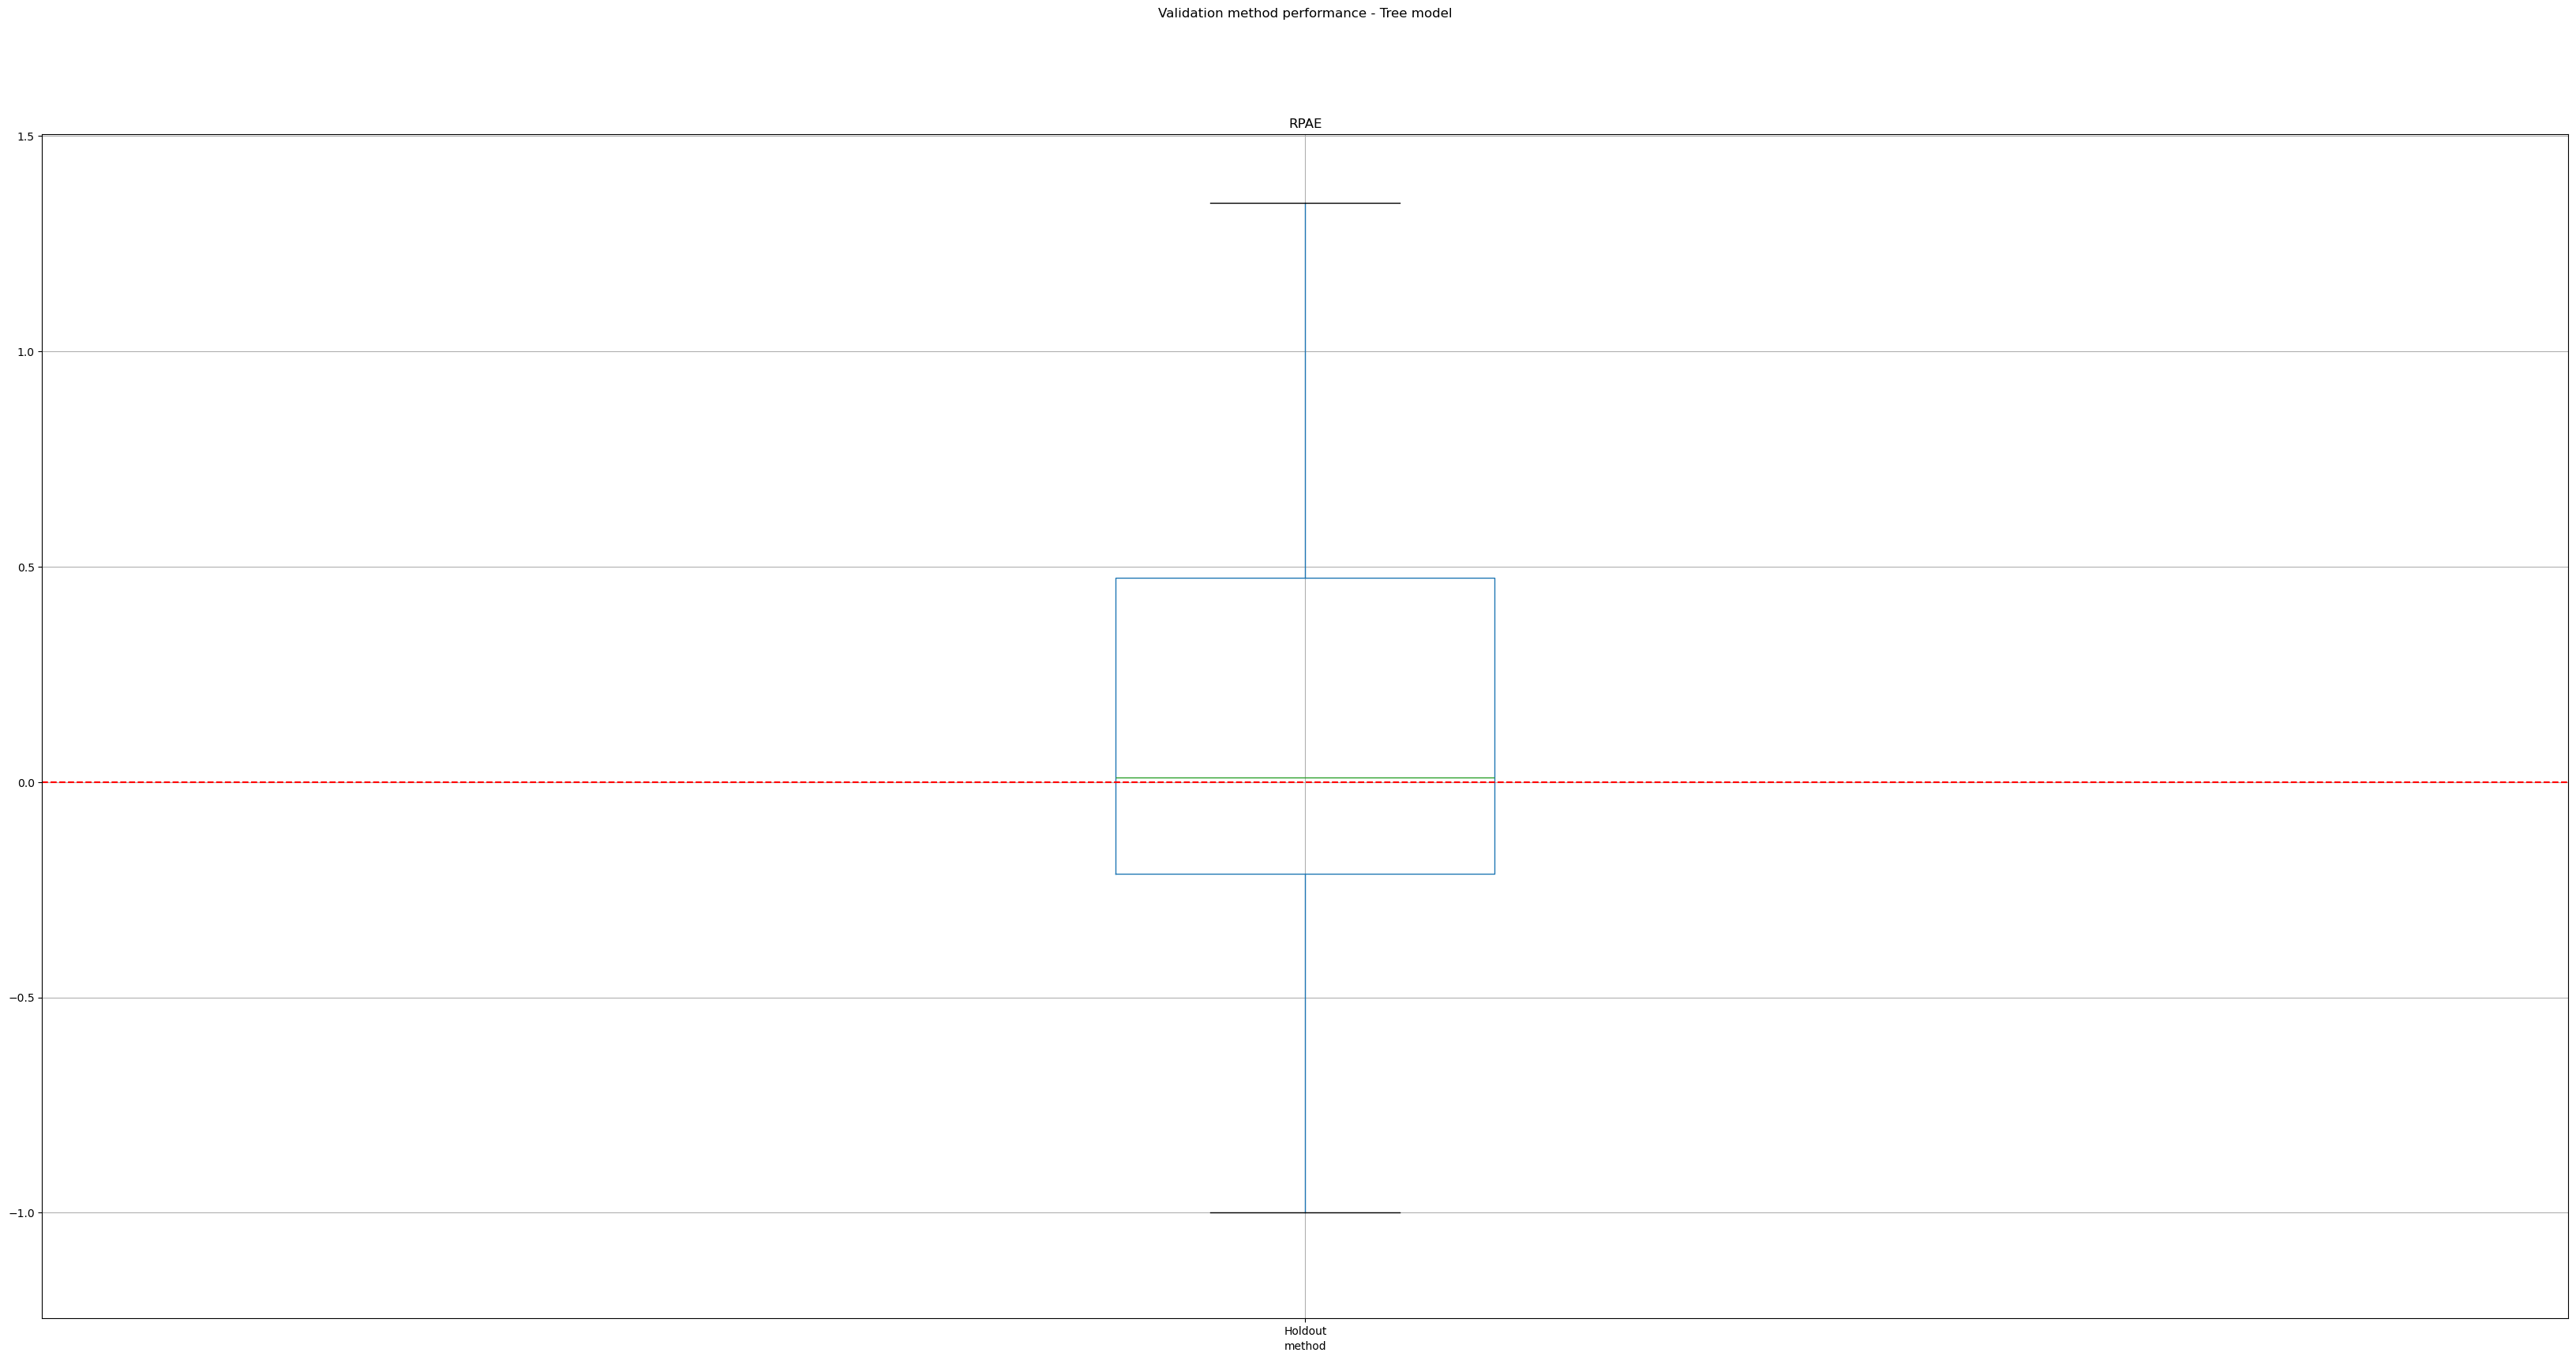

In [21]:
methods = ['Holdout', 'Repeated Holdout']
it = iteration_data.loc[iteration_data["method"].isin(methods)].copy()
boxplots(it, "mse", "Tree", ["RPAE"], 20, 40, shows_outliers=False)

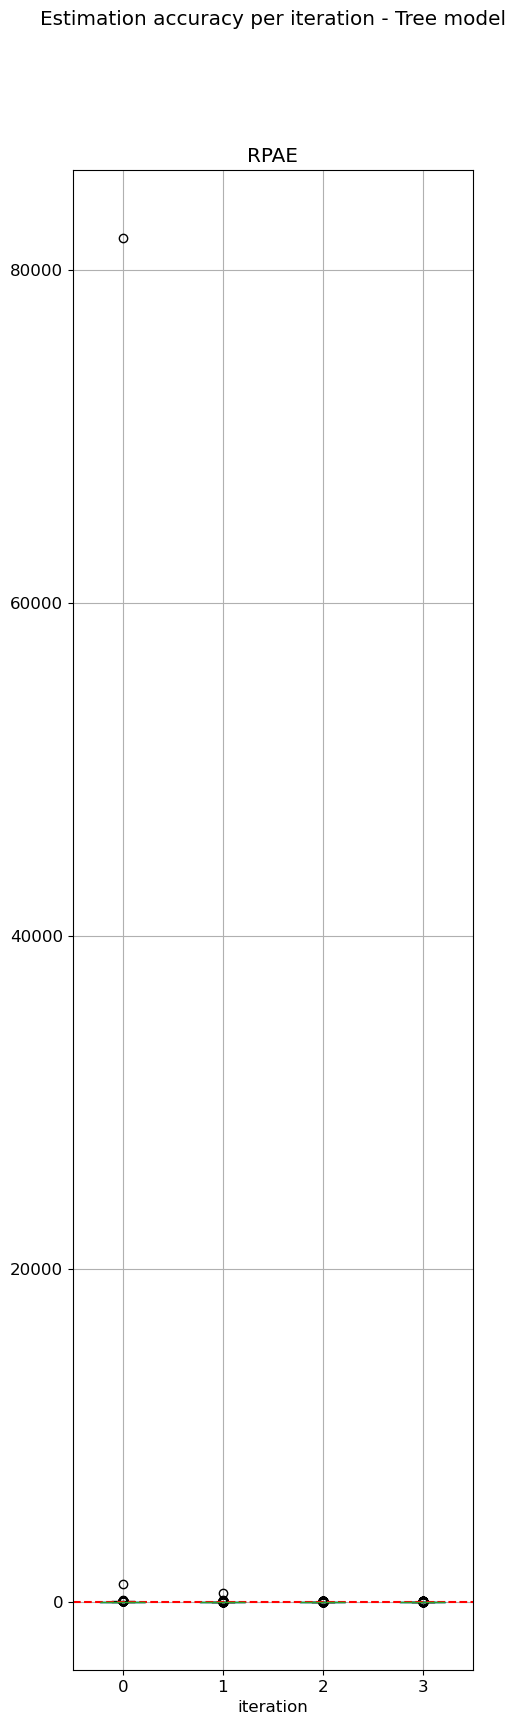

In [22]:
boxplots_per_iteration(iteration_data, "mae", "Tree", "Growing_Window", ["RPAE"], 20, 5);

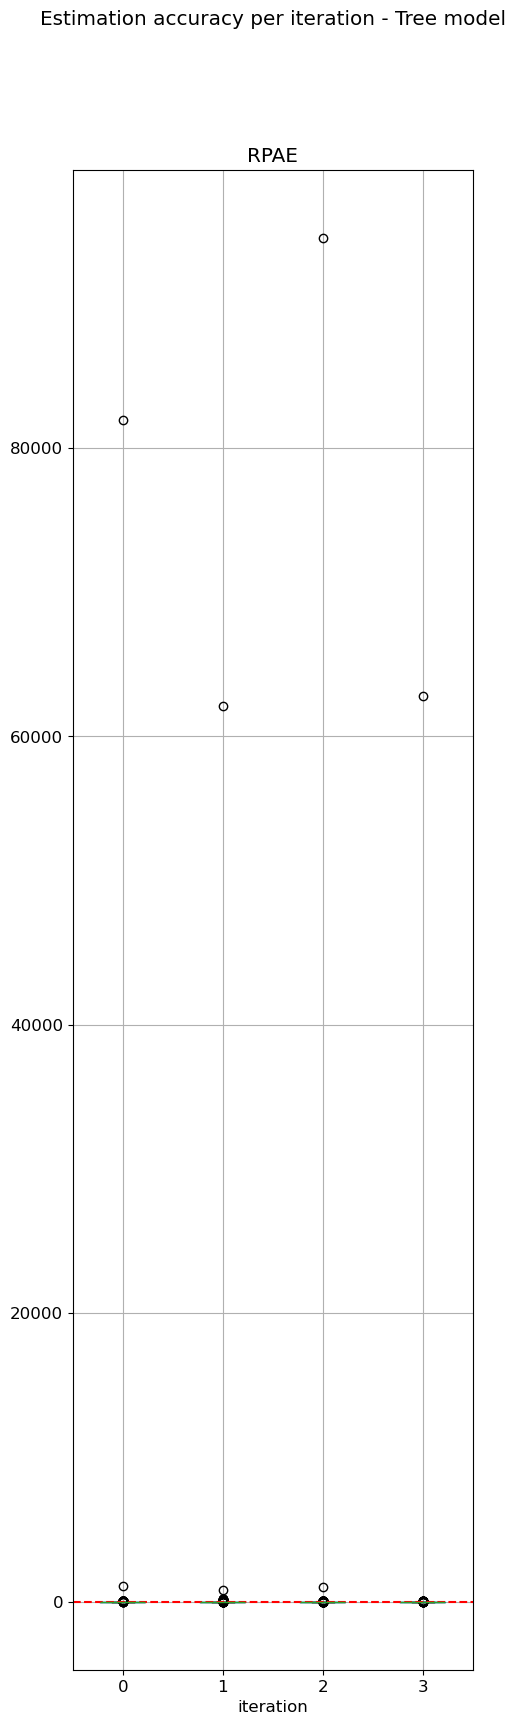

In [23]:
boxplots_per_iteration(iteration_data, "mae", "Tree", "Rolling_Window", ["RPAE"], 20, 5);

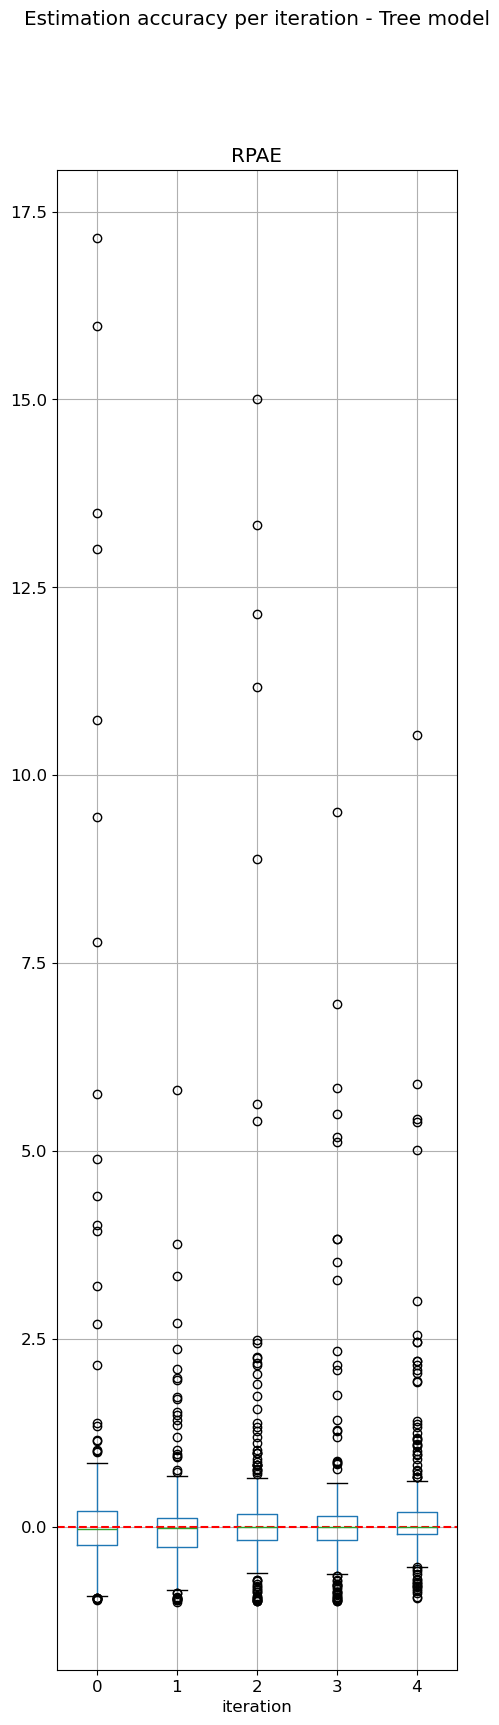

In [24]:
boxplots_per_iteration(iteration_data, "mae", "Tree", "Block_CV", ["RPAE"], 20, 5);